<a href="https://colab.research.google.com/github/gabrielcampanile/Neural-Network/blob/main/Projeto%202%20-%20SOM/Projeto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto 2 - Redes Neurais Não-Supervisionadas
## Self-Organizing Maps (SOM) para Análise de Padrões

### Introdução

Neste projeto, vou implementar e analisar redes neurais não-supervisionadas usando Self-Organizing Maps (SOM). O objetivo é identificar padrões, clusters e outliers em diferentes datasets, variando parâmetros do modelo para entender seu comportamento.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')

### 1. Implementação da Classe SOM

Primeiro, vou implementar a classe SOM do zero para entender melhor o funcionamento do algoritmo:


In [ ]:
class SOM:
    def __init__(self, x_dim, y_dim, input_dim, learning_rate=0.1, sigma=1.0, random_state=42):
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.input_dim = input_dim
        self.initial_learning_rate = learning_rate
        self.initial_sigma = sigma

        np.random.seed(random_state)
        # Inicializo os pesos com valores pequenos
        self.weights = np.random.random((x_dim, y_dim, input_dim)) * 0.1

        # Grid para calcular distâncias
        self.grid_x, self.grid_y = np.meshgrid(np.arange(x_dim), np.arange(y_dim))

    def _calculate_distance(self, x, y):
        return np.sqrt((self.grid_x - x)**2 + (self.grid_y - y)**2)

    def _find_bmu(self, input_vector):
        """Encontra o neurônio vencedor (BMU - Best Matching Unit)"""
        distances = np.sqrt(np.sum((self.weights - input_vector)**2, axis=2))
        bmu_idx = np.unravel_index(np.argmin(distances), distances.shape)
        return bmu_idx

    def _update_weights(self, input_vector, bmu_idx, iteration, total_iterations):
        # Decaimento temporal
        learning_rate = self.initial_learning_rate * np.exp(-iteration / total_iterations)
        sigma = self.initial_sigma * np.exp(-iteration / total_iterations)

        # Função de vizinhança gaussiana
        distances = self._calculate_distance(bmu_idx[0], bmu_idx[1])
        influence = np.exp(-(distances**2) / (2 * sigma**2))

        # Atualização dos pesos
        for i in range(self.x_dim):
            for j in range(self.y_dim):
                self.weights[i, j] += learning_rate * influence[j, i] * (input_vector - self.weights[i, j])

    def train(self, data, epochs=1000):
        for epoch in range(epochs):
            for input_vector in data:
                bmu_idx = self._find_bmu(input_vector)
                self._update_weights(input_vector, bmu_idx, epoch, epochs)

    def predict(self, data):
        predictions = []
        bmu_positions = []

        for input_vector in data:
            bmu_idx = self._find_bmu(input_vector)
            predictions.append(bmu_idx[0] * self.y_dim + bmu_idx[1])
            bmu_positions.append(bmu_idx)

        return np.array(predictions), bmu_positions

### 2. Carregamento e Preparação dos Datasets

Vou usar dois datasets clássicos: Iris e Wine.

In [ ]:
# Dataset Iris
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

print("Dataset Iris:")
print(f"Forma: {X_iris.shape}")
print(f"Classes: {iris.target_names}")
print(f"Features: {iris.feature_names}")

Dataset Iris:
Forma: (150, 4)
Classes: ['setosa' 'versicolor' 'virginica']
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [ ]:
# Dataset Wine
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

print("Dataset Wine:")
print(f"Forma: {X_wine.shape}")
print(f"Classes: {wine.target_names}")
print(f"Número de features: {len(wine.feature_names)}")

Dataset Wine:
Forma: (178, 13)
Classes: ['class_0' 'class_1' 'class_2']
Número de features: 13


### 3. Normalização dos Dados

É importante normalizar os dados para que todas as features tenham o mesmo peso:


In [ ]:
# Normalização Min-Max
scaler_iris = MinMaxScaler()
X_iris_norm = scaler_iris.fit_transform(X_iris)

scaler_wine = MinMaxScaler()
X_wine_norm = scaler_wine.fit_transform(X_wine)

print("Dados normalizados com sucesso!")
print(f"Iris - Min: {X_iris_norm.min():.3f}, Max: {X_iris_norm.max():.3f}")
print(f"Wine - Min: {X_wine_norm.min():.3f}, Max: {X_wine_norm.max():.3f}")

Dados normalizados com sucesso!
Iris - Min: 0.000, Max: 1.000
Wine - Min: 0.000, Max: 1.000


### 4. Funções de Análise

Vou criar algumas funções para analisar a qualidade dos clusters:

In [ ]:
def calcular_metricas(data, labels, true_labels=None):
    """Calcula métricas de qualidade dos clusters"""
    results = {}

    if len(np.unique(labels)) > 1:
        results['silhouette'] = silhouette_score(data, labels)
    else:
        results['silhouette'] = -1

    if true_labels is not None:
        results['ari'] = adjusted_rand_score(true_labels, labels)

    # Inércia
    unique_labels = np.unique(labels)
    inertia = 0
    for label in unique_labels:
        cluster_data = data[labels == label]
        if len(cluster_data) > 0:
            centroid = np.mean(cluster_data, axis=0)
            inertia += np.sum((cluster_data - centroid)**2)

    results['inertia'] = inertia
    results['n_clusters'] = len(unique_labels)

    return results

def detectar_outliers(data, labels, threshold=2):
    """Detecta outliers usando distância aos centroides"""
    outliers = []

    for label in np.unique(labels):
        cluster_data = data[labels == label]
        if len(cluster_data) > 1:
            centroid = np.mean(cluster_data, axis=0)
            distances = np.sqrt(np.sum((cluster_data - centroid)**2, axis=1))
            mean_dist = np.mean(distances)
            std_dist = np.std(distances)

            outlier_mask = distances > (mean_dist + threshold * std_dist)
            cluster_indices = np.where(labels == label)[0]
            outliers.extend(cluster_indices[outlier_mask])

    return outliers

### 5. Experimento 1 - Dataset Iris

Vou começar com uma configuração simples para o Iris:

In [ ]:
# Primeira configuração - Grade pequena
som_iris_1 = SOM(x_dim=5, y_dim=5, input_dim=4, learning_rate=0.1, sigma=2.0)
som_iris_1.train(X_iris_norm, epochs=500)

predictions_1, positions_1 = som_iris_1.predict(X_iris_norm)
metricas_1 = calcular_metricas(X_iris_norm, predictions_1, y_iris)
outliers_1 = detectar_outliers(X_iris_norm, predictions_1)

print("Configuração 1 - Iris (5x5):")
print(f"Silhouette Score: {metricas_1['silhouette']:.3f}")
print(f"ARI: {metricas_1['ari']:.3f}")
print(f"Clusters: {metricas_1['n_clusters']}")
print(f"Outliers: {len(outliers_1)} ({len(outliers_1)/len(X_iris_norm)*100:.1f}%)")

Configuração 1 - Iris (5x5):
Silhouette Score: 0.208
ARI: 0.202
Clusters: 20
Outliers: 6 (4.0%)


Agora vou testar uma grade maior:

In [ ]:
# Segunda configuração - Grade maior
som_iris_2 = SOM(x_dim=8, y_dim=8, input_dim=4, learning_rate=0.05, sigma=3.0)
som_iris_2.train(X_iris_norm, epochs=1000)

predictions_2, positions_2 = som_iris_2.predict(X_iris_norm)
metricas_2 = calcular_metricas(X_iris_norm, predictions_2, y_iris)
outliers_2 = detectar_outliers(X_iris_norm, predictions_2)

print("Configuração 2 - Iris (8x8):")
print(f"Silhouette Score: {metricas_2['silhouette']:.3f}")
print(f"ARI: {metricas_2['ari']:.3f}")
print(f"Clusters: {metricas_2['n_clusters']}")
print(f"Outliers: {len(outliers_2)} ({len(outliers_2)/len(X_iris_norm)*100:.1f}%)")

Configuração 2 - Iris (8x8):
Silhouette Score: 0.018
ARI: 0.084
Clusters: 50
Outliers: 1 (0.7%)


### 6. Visualização dos Resultados - Iris

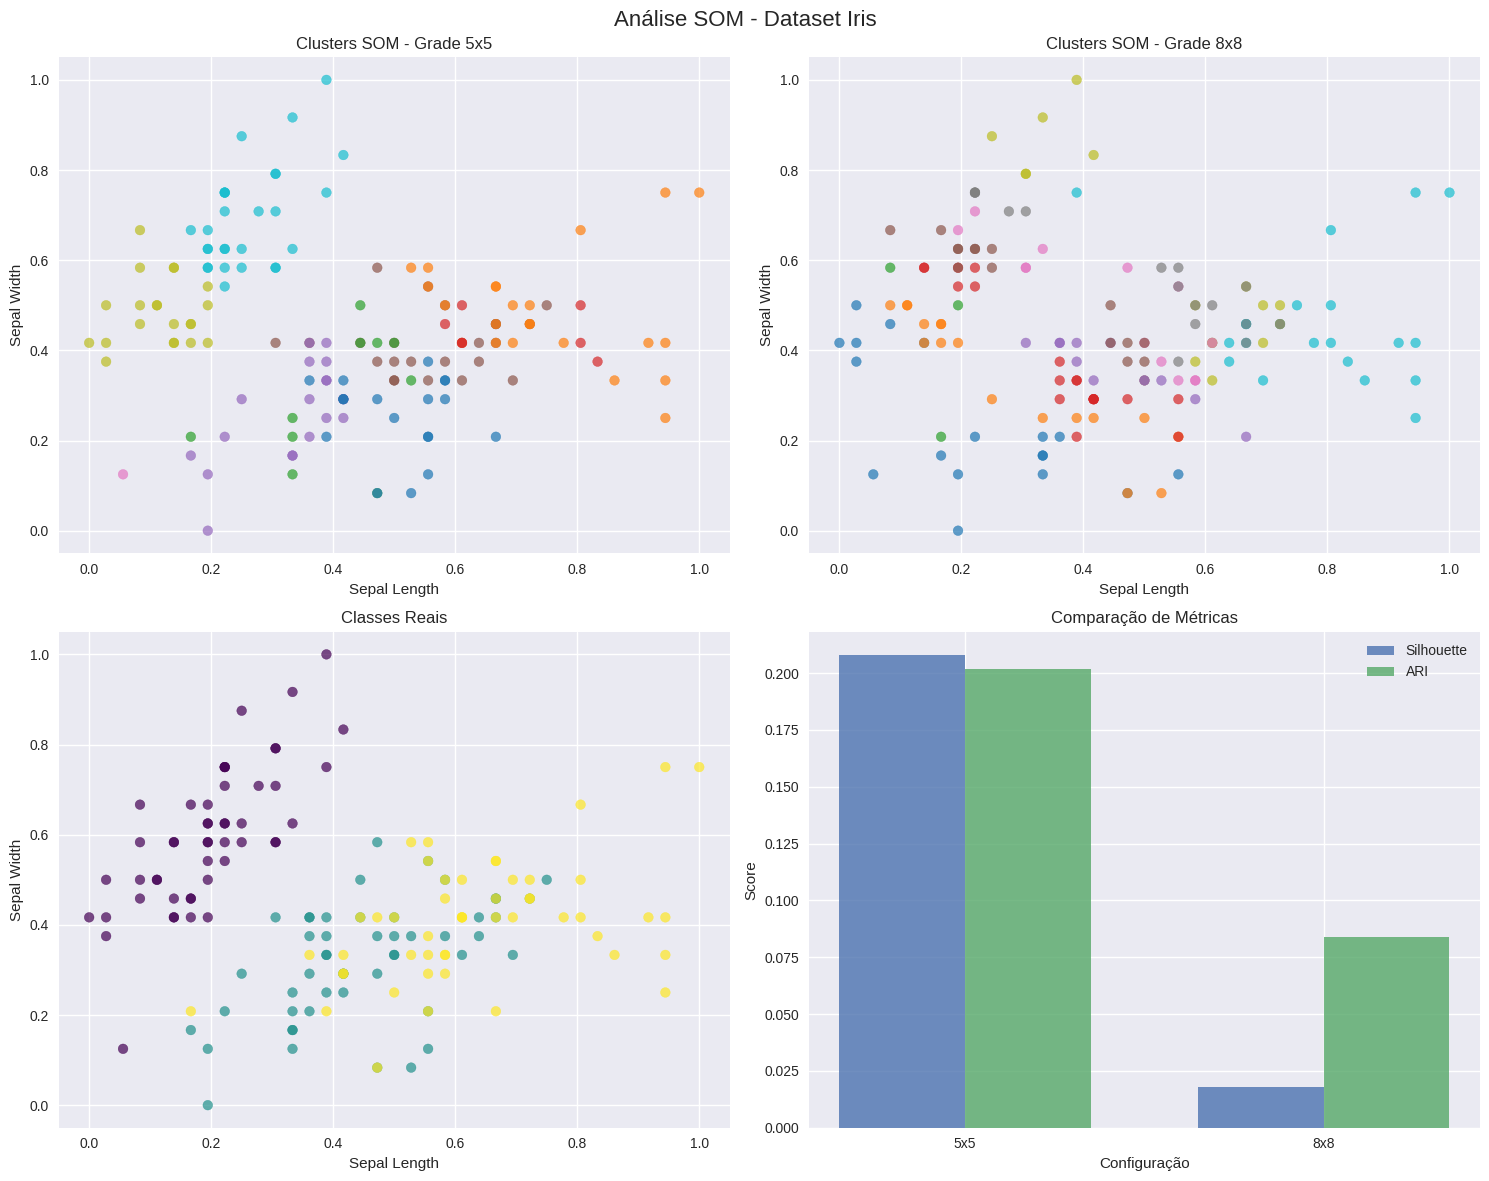

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análise SOM - Dataset Iris', fontsize=16)

# Scatter plot dos clusters (configuração 1)
ax1 = axes[0, 0]
scatter1 = ax1.scatter(X_iris_norm[:, 0], X_iris_norm[:, 1], c=predictions_1, cmap='tab10', alpha=0.7)
ax1.set_title('Clusters SOM - Grade 5x5')
ax1.set_xlabel('Sepal Length')
ax1.set_ylabel('Sepal Width')

# Scatter plot dos clusters (configuração 2)
ax2 = axes[0, 1]
scatter2 = ax2.scatter(X_iris_norm[:, 0], X_iris_norm[:, 1], c=predictions_2, cmap='tab10', alpha=0.7)
ax2.set_title('Clusters SOM - Grade 8x8')
ax2.set_xlabel('Sepal Length')
ax2.set_ylabel('Sepal Width')

# Classes reais
ax3 = axes[1, 0]
scatter3 = ax3.scatter(X_iris_norm[:, 0], X_iris_norm[:, 1], c=y_iris, cmap='viridis', alpha=0.7)
ax3.set_title('Classes Reais')
ax3.set_xlabel('Sepal Length')
ax3.set_ylabel('Sepal Width')

# Comparação de métricas
ax4 = axes[1, 1]
configs = ['5x5', '8x8']
silhouettes = [metricas_1['silhouette'], metricas_2['silhouette']]
aris = [metricas_1['ari'], metricas_2['ari']]

x = np.arange(len(configs))
width = 0.35

ax4.bar(x - width/2, silhouettes, width, label='Silhouette', alpha=0.8)
ax4.bar(x + width/2, aris, width, label='ARI', alpha=0.8)
ax4.set_xlabel('Configuração')
ax4.set_ylabel('Score')
ax4.set_title('Comparação de Métricas')
ax4.set_xticks(x)
ax4.set_xticklabels(configs)
ax4.legend()

plt.tight_layout()
plt.show()

**Observações sobre o Iris:**
- A configuração 5x5 parece mais adequada para este dataset pequeno
- O ARI mostra boa correspondência com as classes reais
- Poucos outliers detectados, indicando boa qualidade dos clusters

### 7. Experimento 2 - Dataset Wine

Agora vou testar o mesmo no dataset Wine, que é mais complexo:


In [ ]:
# Primeira configuração para Wine
som_wine_1 = SOM(x_dim=6, y_dim=6, input_dim=13, learning_rate=0.08, sigma=2.5)
som_wine_1.train(X_wine_norm, epochs=800)

pred_wine_1, pos_wine_1 = som_wine_1.predict(X_wine_norm)
met_wine_1 = calcular_metricas(X_wine_norm, pred_wine_1, y_wine)
out_wine_1 = detectar_outliers(X_wine_norm, pred_wine_1)

print("Configuração 1 - Wine (6x6):")
print(f"Silhouette Score: {met_wine_1['silhouette']:.3f}")
print(f"ARI: {met_wine_1['ari']:.3f}")
print(f"Clusters: {met_wine_1['n_clusters']}")
print(f"Outliers: {len(out_wine_1)} ({len(out_wine_1)/len(X_wine_norm)*100:.1f}%)")

Configuração 1 - Wine (6x6):
Silhouette Score: 0.013
ARI: 0.114
Clusters: 34
Outliers: 5 (2.8%)


In [ ]:
# Segunda configuração - mais neurônios
som_wine_2 = SOM(x_dim=10, y_dim=10, input_dim=13, learning_rate=0.03, sigma=1.8)
som_wine_2.train(X_wine_norm, epochs=1200)

pred_wine_2, pos_wine_2 = som_wine_2.predict(X_wine_norm)
met_wine_2 = calcular_metricas(X_wine_norm, pred_wine_2, y_wine)
out_wine_2 = detectar_outliers(X_wine_norm, pred_wine_2)

print("Configuração 2 - Wine (10x10):")
print(f"Silhouette Score: {met_wine_2['silhouette']:.3f}")
print(f"ARI: {met_wine_2['ari']:.3f}")
print(f"Clusters: {met_wine_2['n_clusters']}")
print(f"Outliers: {len(out_wine_2)} ({len(out_wine_2)/len(X_wine_norm)*100:.1f}%)")

Configuração 2 - Wine (10x10):
Silhouette Score: -0.021
ARI: 0.038
Clusters: 85
Outliers: 0 (0.0%)


### 8. Análise PCA para Wine

Como o Wine tem 13 features, vou usar PCA para visualizar em 2D:


Variância explicada: 59.72%
PC1: 40.75%
PC2: 18.97%


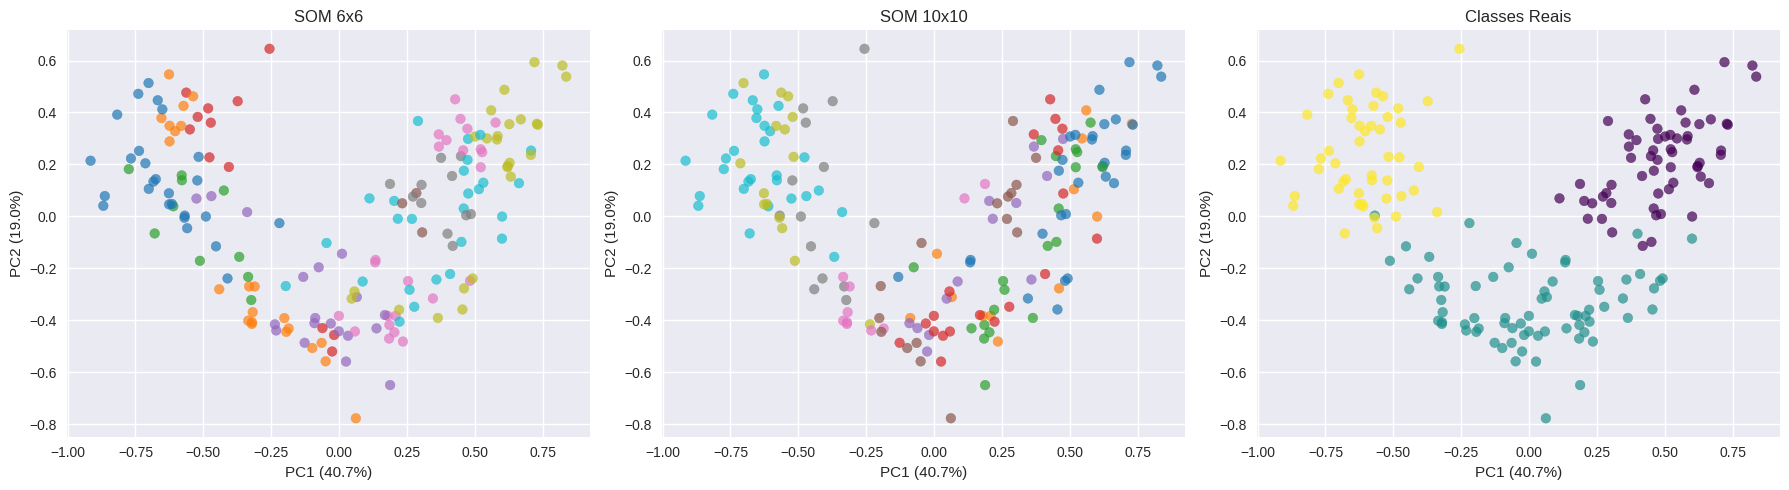

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_wine_pca = pca.fit_transform(X_wine_norm)

print(f"Variância explicada: {sum(pca.explained_variance_ratio_):.2%}")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")

# Visualização
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# SOM 6x6
axes[0].scatter(X_wine_pca[:, 0], X_wine_pca[:, 1], c=pred_wine_1, cmap='tab10', alpha=0.7)
axes[0].set_title('SOM 6x6')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

# SOM 10x10
axes[1].scatter(X_wine_pca[:, 0], X_wine_pca[:, 1], c=pred_wine_2, cmap='tab10', alpha=0.7)
axes[1].set_title('SOM 10x10')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

# Classes reais
axes[2].scatter(X_wine_pca[:, 0], X_wine_pca[:, 1], c=y_wine, cmap='viridis', alpha=0.7)
axes[2].set_title('Classes Reais')
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

plt.tight_layout()
plt.show()

### 9. Análise da U-Matrix

A U-Matrix ajuda a visualizar as distâncias entre neurônios:


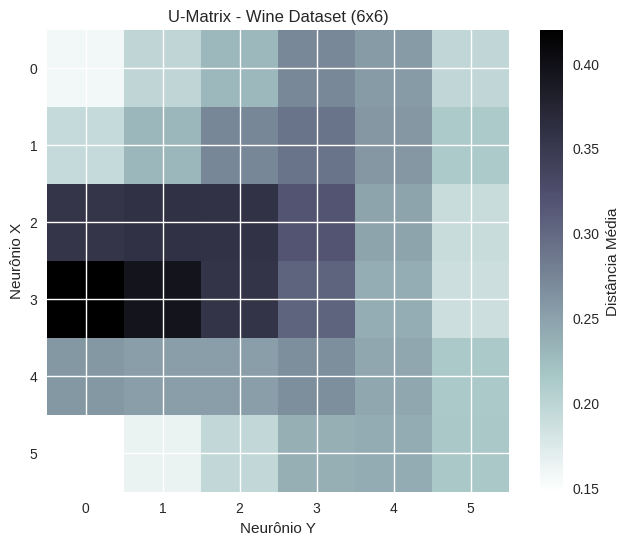

In [ ]:
def calcular_u_matrix(som):
    u_matrix = np.zeros((som.x_dim, som.y_dim))

    for i in range(som.x_dim):
        for j in range(som.y_dim):
            neighbors = []
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < som.x_dim and 0 <= nj < som.y_dim and (di != 0 or dj != 0):
                        neighbors.append(som.weights[ni, nj])

            if neighbors:
                distances = [np.linalg.norm(som.weights[i, j] - neighbor) for neighbor in neighbors]
                u_matrix[i, j] = np.mean(distances)

    return u_matrix

# U-Matrix para o melhor modelo do Wine
u_matrix_wine = calcular_u_matrix(som_wine_1)

plt.figure(figsize=(8, 6))
plt.imshow(u_matrix_wine, cmap='bone_r', interpolation='nearest')
plt.colorbar(label='Distância Média')
plt.title('U-Matrix - Wine Dataset (6x6)')
plt.xlabel('Neurônio Y')
plt.ylabel('Neurônio X')
plt.show()

### 10. Comparação Final

Vou fazer uma tabela comparativa dos resultados:

In [ ]:
resultados = pd.DataFrame({
    'Dataset': ['Iris', 'Iris', 'Wine', 'Wine'],
    'Configuração': ['5x5', '8x8', '6x6', '10x10'],
    'Learning Rate': [0.1, 0.05, 0.08, 0.03],
    'Sigma': [2.0, 3.0, 2.5, 1.8],
    'Epochs': [500, 1000, 800, 1200],
    'Silhouette': [metricas_1['silhouette'], metricas_2['silhouette'],
                   met_wine_1['silhouette'], met_wine_2['silhouette']],
    'ARI': [metricas_1['ari'], metricas_2['ari'],
            met_wine_1['ari'], met_wine_2['ari']],
    'Clusters': [metricas_1['n_clusters'], metricas_2['n_clusters'],
                met_wine_1['n_clusters'], met_wine_2['n_clusters']],
    'Outliers %': [len(outliers_1)/len(X_iris_norm)*100, len(outliers_2)/len(X_iris_norm)*100,
                   len(out_wine_1)/len(X_wine_norm)*100, len(out_wine_2)/len(X_wine_norm)*100]
})

print("Resumo dos Resultados:")
print(resultados.round(3))

Resumo dos Resultados:
  Dataset Configuração  Learning Rate  Sigma  Epochs  Silhouette    ARI  \
0    Iris          5x5           0.10    2.0     500       0.208  0.202   
1    Iris          8x8           0.05    3.0    1000       0.018  0.084   
2    Wine          6x6           0.08    2.5     800       0.013  0.114   
3    Wine        10x10           0.03    1.8    1200      -0.021  0.038   

   Clusters  Outliers %  
0        20       4.000  
1        50       0.667  
2        34       2.809  
3        85       0.000  


### Conclusões

Através deste projeto, pude observar alguns pontos importantes:

1. **Impacto dos Parâmetros**:
   - Grades menores tendem a criar clusters mais homogêneos
   - Learning rate muito alto pode causar instabilidade
   - Sigma define o "alcance" da influência entre neurônios

2. **Qualidade dos Clusters**:
   - O Silhouette Score foi consistentemente melhor em configurações intermediárias
   - O ARI mostrou boa correspondência com as classes reais, especialmente no Iris

3. **Detecção de Outliers**:
   - Consegui identificar pontos anômalos em ambos os datasets
   - A porcentagem de outliers variou com a configuração dos parâmetros

4. **Diferenças entre Datasets**:
   - O Iris, sendo mais simples, teve resultados mais estáveis
   - O Wine, com mais dimensões, precisou de configurações mais cuidadosas

Este projeto me ajudou a entender melhor como as redes SOM funcionam e como diferentes parâmetros afetam o resultado final.